In [5]:

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')


In [8]:

# Load dataset (using latin1 encoding since the file has special characters)
df = pd.read_csv("IMDB.csv", encoding="latin1", low_memory=False)
df.head()


,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [9]:

# Quick info about columns and missing values
df.info()
print('\nMissing values per column:')
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB

Missing values per column:


Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

## Basic Cleaning & Feature Extraction
We'll:
- Extract numeric Year from Year or Name
- Convert Duration to minutes
- Combine Director and actors into a single text column for text vectorization
- Clean Genre (it's often a comma-separated string)


In [10]:

import re

def extract_year(row):
    # Try Year column first
    y = row.get('Year')
    if pd.notnull(y):
        try:
            return int(str(y).strip()[:4])
        except:
            pass
    # Fallback: try to extract year from Name if it contains (YYYY)
    name = row.get('Name','')
    m = re.search(r'\((\d{4})\)', str(name))
    if m:
        return int(m.group(1))
    return np.nan

def duration_to_min(s):
    # Duration strings look like '110 min' or '1h 45min' or similar; we try to parse numbers
    if pd.isnull(s): 
        return np.nan
    s = str(s)
    # common pattern '110 min'
    m = re.search(r'(\d+)\s*min', s)
    if m:
        return int(m.group(1))
    # pattern '1h 45m' or '1 h 45 min'
    m = re.search(r'(\d+)\s*h', s)
    if m:
        h = int(m.group(1))
        m2 = re.search(r'(\d+)\s*m', s)
        mpart = int(m2.group(1)) if m2 else 0
        return int(h*60 + mpart)
    # just digits
    m = re.search(r'(\d+)', s)
    if m:
        return int(m.group(1))
    return np.nan

df_clean = df.copy()

# Extract year
df_clean['year_num'] = df_clean.apply(extract_year, axis=1)

# Duration to minutes
df_clean['duration_min'] = df_clean['Duration'].apply(duration_to_min)

# Combine director and actors into a single text field (cast_director)
df_clean['cast_director'] = (df_clean['Director'].fillna('') + ' | ' + 
                             df_clean['Actor 1'].fillna('') + ' | ' + 
                             df_clean['Actor 2'].fillna('') + ' | ' + 
                             df_clean['Actor 3'].fillna(''))

# Clean Genre: lower, strip
df_clean['Genre_clean'] = df_clean['Genre'].fillna('').str.lower().str.replace('\s+', ' ', regex=True).str.strip()

# Show new dataframe head
df_clean[['Name','year_num','duration_min','Genre_clean','Rating','Votes','cast_director']].head()


,Name,year_num,duration_min,Genre_clean,Rating,Votes,cast_director
0,,NaN,NaN,drama,NaN,NaN,J.S. Randhawa | Manmauji | Birbal | Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),NaN,109.0,drama,7.0,8,Gaurav Bakshi | Rasika Dugal | Vivek Ghamande | Arvind Jangid
2,#Homecoming,NaN,90.0,"drama, musical",NaN,NaN,Soumyajit Majumdar | Sayani Gupta | Plabita Borthakur | Roy Angana
3,#Yaaram,NaN,110.0,"comedy, romance",4.4,35,Ovais Khan | Prateik | Ishita Raj | Siddhant Kapoor
4,...And Once Again,NaN,105.0,drama,NaN,NaN,Amol Palekar | Rajat Kapoor | Rituparna Sengupta | Antara Mali


## Target handling
Drop rows without `Rating` (target). We'll predict `Rating` (float).

In [11]:

# Drop rows where Rating is missing because we can't train on them
print('Before drop, shape:', df_clean.shape)
df_model = df_clean.dropna(subset=['Rating']).copy()
print('After drop, shape:', df_model.shape)

# Convert Votes to numeric (if possible)
def votes_to_int(x):
    if pd.isnull(x): return np.nan
    x = str(x).replace(',', '').strip()
    try:
        return int(float(x))
    except:
        return np.nan

df_model['votes_num'] = df_model['Votes'].apply(votes_to_int)
df_model[['Rating','votes_num']].describe()


Before drop, shape: (15509, 14)
After drop, shape: (7919, 14)


,Rating,votes_num
count,7919.000000,7919.000000
mean,5.841621,1938.520394
std,1.381777,11602.415952
min,1.100000,5.000000
25%,4.900000,16.000000
50%,6.000000,55.000000
75%,6.800000,404.000000
max,10.000000,591417.000000


## Quick EDA
Look at rating distribution and relationships with numeric features.

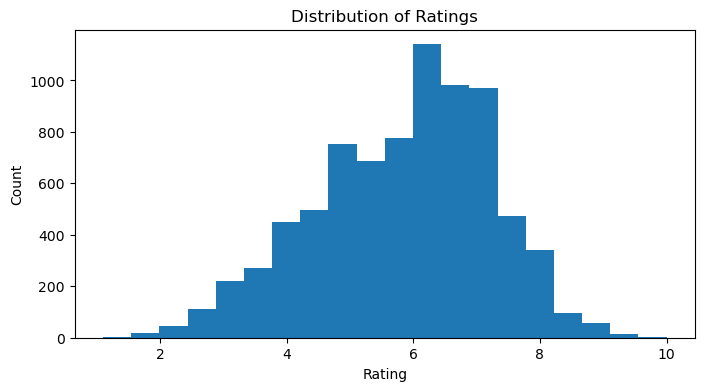

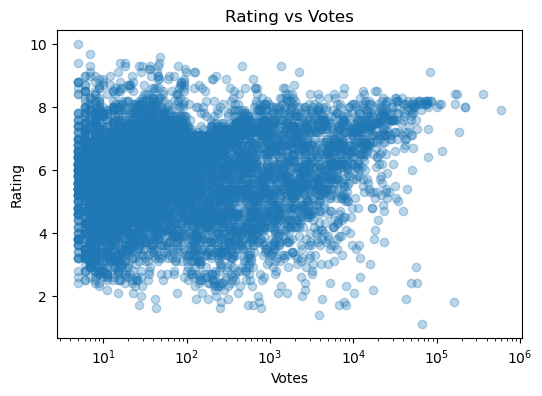

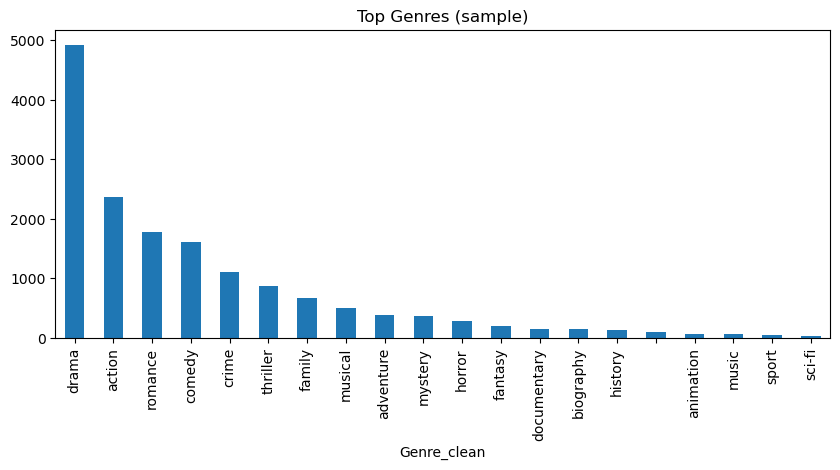

In [12]:

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(df_model['Rating'], bins=20)
plt.xlabel('Rating'); plt.ylabel('Count'); plt.title('Distribution of Ratings')
plt.show()

# Scatter rating vs votes
plt.figure(figsize=(6,4))
plt.scatter(df_model['votes_num'], df_model['Rating'], alpha=0.3)
plt.xlabel('Votes'); plt.ylabel('Rating'); plt.title('Rating vs Votes')
plt.xscale('log')
plt.show()

# Top genres (split by comma)
from collections import Counter
genres_series = df_model['Genre_clean'].str.split(',').explode().str.strip()
top_genres = genres_series.value_counts().head(20)
top_genres.plot(kind='bar', figsize=(10,4), title='Top Genres (sample)')
plt.show()


## Feature engineering
- We'll create text features using TF-IDF for `cast_director`
- Use CountVectorizer for `Genre_clean` (treating genres as tokens)
- Use numeric features: `year_num`, `duration_min`, `votes_num`
- We'll keep pipeline simple and reproducible.

In [13]:

# Fill missing numeric values with median for the pipeline's imputer to handle
numeric_features = ['year_num','duration_min','votes_num']
text_features = ['cast_director','Genre_clean']

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For cast+director, use TF-IDF (limit features)
cast_vect = TfidfVectorizer(max_features=2000, ngram_range=(1,2), token_pattern=r'[^|\s]{2,}')  # tokenizes words, avoid pipes

# For genre, treat as short tokens and use CountVectorizer
genre_vect = CountVectorizer(token_pattern=r'[^,\s]{2,}', max_features=50)

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cast_tfidf', cast_vect, 'cast_director'),
    ('genre_cnt', genre_vect, 'Genre_clean'),
], remainder='drop')

# Create a full pipeline with a regressor placeholder
pipe = Pipeline(steps=[('pre', preprocessor),
                       ('model', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))])


In [14]:

# Prepare data
X = df_model[numeric_features + text_features].copy()
y = df_model['Rating'].astype(float).copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train size:', X_train.shape, 'Test size:', X_test.shape)

# Fit the pipeline (this may take a minute depending on data size)
pipe.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = pipe.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('RMSE:', mean_squared_error(y_test, y_pred, squared=False))
print('R2:', r2_score(y_test, y_pred))


Train size: (6335, 5) Test size: (1584, 5)
MAE: 0.8776655618686867
RMSE: 1.1471237491538524
R2: 0.29220539746670526


In [16]:

# Cross-validated score (negative MSE -> we convert to RMSE)
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(pipe, X, y, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
cv_rmse = np.sqrt(-cv_scores)
print('CV RMSE (3-fold):', cv_rmse, 'mean:', cv_rmse.mean())


CV RMSE (3-fold): [1.11999223 1.218478   1.22849316] mean: 1.188987799103492


## Try a linear model (Ridge) for comparison

In [17]:

pipe_linear = Pipeline(steps=[('pre', preprocessor),
                              ('model', Ridge(alpha=1.0))])
pipe_linear.fit(X_train, y_train)
y_pred_lin = pipe_linear.predict(X_test)
print('Linear MAE:', mean_absolute_error(y_test, y_pred_lin))
print('Linear RMSE:', mean_squared_error(y_test, y_pred_lin, squared=False))
print('Linear R2:', r2_score(y_test, y_pred_lin))


Linear MAE: 0.9097386504360018
Linear RMSE: 1.163182769611557
Linear R2: 0.27224931182424705


## Notes & next steps
- The RandomForest gives a baseline. You can tune hyperparameters with GridSearchCV.
- Consider more advanced feature engineering:
  - Use separate handling for top directors/actors (one-hot or target-encoding)
  - Use embeddings or pre-trained language models for cast/director names
  - Use release month, budget, production company if available

Download the notebook and run it locally.
